# Training a simple model

This notebook trains a simple model and saves it to disk.

In [1]:
# Reload imported code automatically.
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

sys.path.append("..")
from src import simplemodel, training, utils
from src.training import Vocabulary

In [3]:
matplotlib.rc("font", **{"size": 14})

## Params

In [4]:
# Data parameters.
DF_PATH = os.path.join("..", "data", "carsWithImageCleaned.csv")
MODEL_NAME = "firstmodel"
HELPER_FILENAME = f"{MODEL_NAME}-helper.pkl"

# Model parameters.
COLS_TO_SCALE = ["Anul", "Km", "Putere (CP)", "Capacitate cilindrica (cm3)", "Numar de portiere", "Consum (l/100km)"]
COLS_NORMAL = ["Fara accident in istoric", "Carte de service", "Filtru de particule", "Inmatriculat"]
COLS_TO_EMBED = ["Marca", "Model", "Combustibil", "Cutie de viteze", "Tip Caroserie", "Culoare", "Tractiune"]
EMBEDDING_DIM = 6
HIDDEN_SIZES = [32, 64, 32]

# Training parameters.
BATCH_SIZE = 128
EPOCHS = 200
LEARNING_RATE = 0.001
TRAIN_SIZE = 0.66

# Miscellaneous.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {DEVICE}")
TORCH_SEED = 13
torch.manual_seed(TORCH_SEED)

Using device cuda


## Loading and preparing the data

In [5]:
df = pd.read_csv(DF_PATH, index_col=0)
df

,Url,Autovit Id,Pret (EUR),Oferit de,Categorie,Marca,Model,Anul,Km,Combustibil,...,Tip Caroserie,Numar de portiere,Culoare,Fara accident in istoric,Carte de service,Tractiune,Filtru de particule,Inmatriculat,Primul proprietar,Consum (l/100km)
0,https://www.autovit.ro/anunt/suzuki-vitara-1-6...,7049990250,16999.0,Proprietar,Autoturisme,Suzuki,Vitara,2018,26000,Benzina,...,SUV,5,Negru,True,True,Nu e mentionat,False,False,Nu,5.800000
1,https://www.autovit.ro/anunt/toyota-auris-1-8-...,7049960669,12500.0,Proprietar,Autoturisme,Toyota,Auris,2015,239465,Hibrid,...,Combi,5,Gri,True,True,Nu e mentionat,False,False,Nu,3.500000
2,https://www.autovit.ro/anunt/skoda-octavia-1-6...,7049895868,14994.0,Firma,Autoturisme,Skoda,Octavia,2020,100000,Diesel,...,Sedan,5,Albastru,True,True,Fata,True,True,Da,4.700000
3,https://www.autovit.ro/anunt/ford-focus-1-6-td...,7049990021,5000.0,Proprietar,Autoturisme,Ford,Focus,2012,245000,Diesel,...,Combi,5,Alb,True,True,Fata,True,True,Nu,5.100000
4,https://www.autovit.ro/anunt/opel-insignia-ID7...,7049990234,17800.0,Proprietar,Autoturisme,Opel,Insignia,2017,65000,Diesel,...,Sedan,4,Alb,True,False,Fata,False,True,Nu,4.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,https://www.autovit.ro/anunt/citron-c4-picasso...,7049523776,6990.0,Firma,Autoturisme,Citroën,C4 Picasso,2012,146000,Diesel,...,Monovolum,5,Alte culori,True,True,Fata,False,False,Da,6.900000
12225,https://www.autovit.ro/anunt/volkswagen-tiguan...,7049904550,18189.0,Firma,Autoturisme,Volkswagen,Tiguan,2018,213850,Diesel,...,SUV,5,Gri,False,False,Fata,True,False,Da,5.700000
12226,https://www.autovit.ro/anunt/hyundai-tucson-2-...,7049121387,17800.0,Firma,Autoturisme,Hyundai,Tucson,2016,113842,Diesel,...,SUV,5,Gri,False,False,4x4,False,False,Nu,6.000000
12227,https://www.autovit.ro/anunt/skoda-citigo-1-0-...,7049459656,6790.0,Firma,Autoturisme,Skoda,Citigo,2015,132879,Benzina,...,Masina mica,5,Alb,True,True,Fata,False,True,Nu,5.600000


Remove cars which are outliers when considering their price.

In [6]:
df = df.drop(df[~utils.inlier_mask(df["Pret (EUR)"])].index)

Form the train/validation datasets.

In [7]:
df_train, df_valid = train_test_split(df, train_size=TRAIN_SIZE, random_state=TORCH_SEED)
print(f"Training set shape:   {df_train.shape}")
print(f"Validation set shape: {df_valid.shape}")

Training set shape:   (7250, 23)
Validation set shape: (3735, 23)


Most features have different scales, and this can affect training. Scaling the
outputs seems to have an important effect on gradients/loss values, as well.

We save the constants needed for scaling into a helper object, which will be
used alongside the model. This object will also store vocabularies for the
categorial features.

In [8]:
input_helper = simplemodel.make_input_helper(
    cols_to_scale=df_train[COLS_TO_SCALE + ["Pret (EUR)"]],
    cols_to_embed=df_train[COLS_TO_EMBED],
)

# Training tensors.
inputs_train, indices_train = simplemodel.make_inputs(
    input_helper,
    cols_to_scale=df_train[COLS_TO_SCALE],
    cols_normal=df_train[COLS_NORMAL],
    cols_to_embed=df_train[COLS_TO_EMBED],
)

prices_train = torch.tensor(df_train["Pret (EUR)"].values)
prices_train /= input_helper.maxes["Pret (EUR)"]

# Validation tensors.
inputs_valid, indices_valid = simplemodel.make_inputs(
    input_helper,
    cols_to_scale=df_valid[COLS_TO_SCALE],
    cols_normal=df_valid[COLS_NORMAL],
    cols_to_embed=df_valid[COLS_TO_EMBED],
)

prices_valid = torch.tensor(df_valid["Pret (EUR)"].values)
prices_valid /= input_helper.maxes["Pret (EUR)"]

Build batched dataloaders to iterate easily through the dataset.

In [9]:
dataset_train = torch.utils.data.TensorDataset(inputs_train, indices_train, prices_train)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)

dataset_valid = torch.utils.data.TensorDataset(inputs_valid, indices_valid, prices_valid)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH_SIZE)

## Training a model

In [10]:
model = simplemodel.SimpleModel(
    input_size=inputs_train.shape[1],
    vocab_lens=[len(input_helper.vocabs[col]) for col in COLS_TO_EMBED],
    embedding_dim=EMBEDDING_DIM,
    hidden_sizes=HIDDEN_SIZES,
)
model.to(DEVICE)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

model

SimpleModel(
  (embeddings): ModuleList(
    (0): Embedding(52, 6, max_norm=1)
    (1): Embedding(425, 6, max_norm=1)
    (2): Embedding(4, 6, max_norm=1)
    (3): Embedding(3, 6, max_norm=1)
    (4): Embedding(10, 6, max_norm=1)
    (5): Embedding(12, 6, max_norm=1)
    (6): Embedding(5, 6, max_norm=1)
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=52, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

The main training loop.

In [11]:
training_info = pd.DataFrame(columns=["epoch", "loss"])

for epoch in range(EPOCHS):

    loss_train = 0
    model.train()
    for x_inputs, x_indices, y in loader_train:
        x_inputs, x_indices, y = x_inputs.to(DEVICE), x_indices.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x_inputs, x_indices).view(-1)
        loss = loss_function(out, y)

        loss.backward()
        optimizer.step()

        loss_train += loss.item()

    loss_valid = 0
    model.eval()
    with torch.no_grad():
        for x_inputs, x_indices, y in loader_valid:
            x_inputs, x_indices, y = x_inputs.to(DEVICE), x_indices.to(DEVICE), y.to(DEVICE)
            out = model(x_inputs, x_indices).view(-1)
            loss = loss_function(out, y)
            loss_valid += loss.item()

    training_info = pd.concat([training_info, pd.DataFrame([{
        "epoch": epoch,
        "loss_train": loss_train,
        "loss_valid": loss_valid,
    }])])

    print(
        f"Epoch {epoch}:\ttrain loss: {loss_train:.5f}\tvalid loss: {loss_valid:.5f}"
    )


Epoch 0:	train loss: 7.45617	valid loss: 3.45600
Epoch 1:	train loss: 5.63057	valid loss: 2.86789
Epoch 2:	train loss: 4.67533	valid loss: 2.45083
Epoch 3:	train loss: 4.09324	valid loss: 2.18184
Epoch 4:	train loss: 3.70293	valid loss: 1.99413
Epoch 5:	train loss: 3.42430	valid loss: 1.85612
Epoch 6:	train loss: 3.21455	valid loss: 1.75015
Epoch 7:	train loss: 3.05078	valid loss: 1.66616
Epoch 8:	train loss: 2.91924	valid loss: 1.59781
Epoch 9:	train loss: 2.81039	valid loss: 1.54060
Epoch 10:	train loss: 2.71805	valid loss: 1.49190
Epoch 11:	train loss: 2.63856	valid loss: 1.45000
Epoch 12:	train loss: 2.56926	valid loss: 1.41330
Epoch 13:	train loss: 2.50782	valid loss: 1.38082
Epoch 14:	train loss: 2.45292	valid loss: 1.35182
Epoch 15:	train loss: 2.40355	valid loss: 1.32583
Epoch 16:	train loss: 2.35880	valid loss: 1.30225
Epoch 17:	train loss: 2.31802	valid loss: 1.28083
Epoch 18:	train loss: 2.28053	valid loss: 1.26114
Epoch 19:	train loss: 2.24571	valid loss: 1.24295
Epoch 20:	

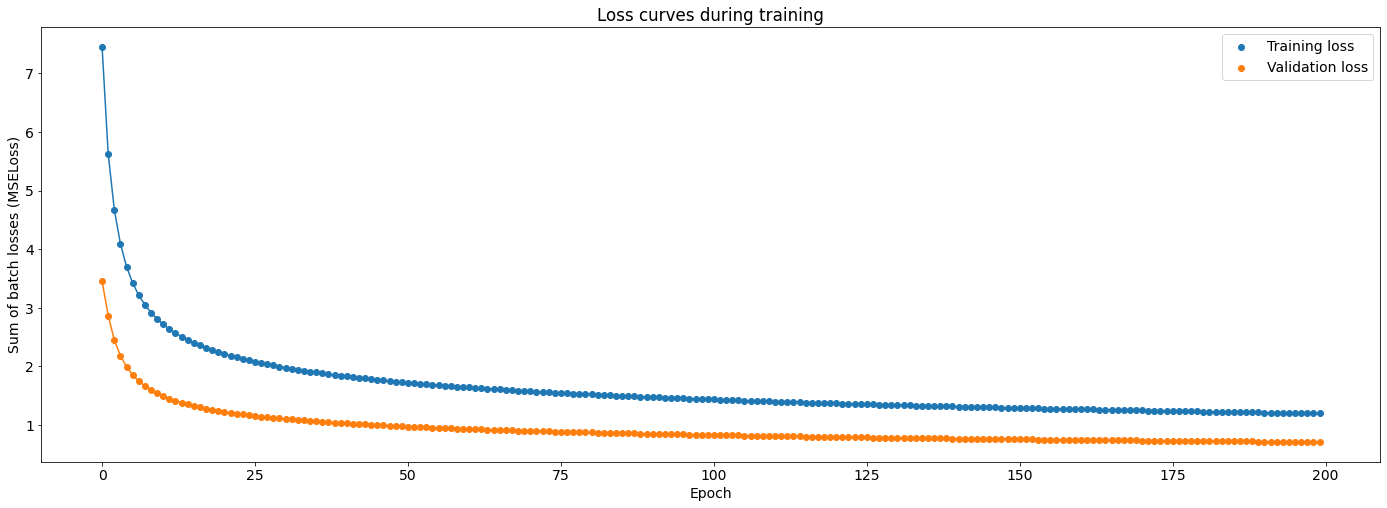

In [12]:
# Plot loss curves.
window = training_info.iloc[:]
plt.figure(figsize=(24, 8))
plt.scatter(data=window, x="epoch", y="loss_train", label="Training loss")
plt.plot("epoch", "loss_train", data=window, label="")
plt.scatter(data=window, x="epoch", y="loss_valid", label="Validation loss")
plt.plot("epoch", "loss_valid", data=window, label="")
plt.title("Loss curves during training")
plt.xlabel("Epoch")
plt.ylabel(f"Sum of batch losses ({loss_function.__class__.__name__})")
plt.legend()
plt.show()

## Predicting prices for unseen inputs

In [13]:
# Making a prediction for unseen input.
# Real input taken from https://www.autovit.ro/anunt/audi-a5-ID7H7Azi.html.
# The real price is 29 990 EUR.

fictional = pd.DataFrame({
    "Oferit de": "Proprietar",
    "Marca": "Audi",
    "Model": "A5",
    "Anul": 2019,
    "Km": 155_000.0,
    "Combustibil": "Diesel",
    "Putere (CP)": 190,
    "Capacitate cilindrica (cm3)": 1998,
    "Cutie de viteze": "Automata",
    "Tip Caroserie": "Sedan",
    "Numar de portiere": 4,
    "Culoare": "Maro",
    "Fara accident in istoric": True,
    "Carte de service": True,
    "Tractiune": "Fata",
    "Filtru de particule": True,
    "Inmatriculat": False,
    "Primul proprietar": False,
    "Consum (l/100km)": 4.8,
}, index=[0])

fictional_inputs, fictional_indices = simplemodel.make_inputs(
    input_helper,
    cols_to_scale=fictional[COLS_TO_SCALE],
    cols_normal=fictional[COLS_NORMAL],
    cols_to_embed=fictional[COLS_TO_EMBED],
)
fictional_inputs = fictional_inputs.to(DEVICE)
fictional_indices = fictional_indices.to(DEVICE)

model.eval()
with torch.no_grad():
    prediction = model(fictional_inputs, fictional_indices).item()

predicted_price = prediction * input_helper.maxes["Pret (EUR)"]
print(f"Predicted price: {predicted_price}")


Predicted price: 21890.45032947116


## Saving the model

We save the weights (and helper information) to disk, to make predictions later.

In [14]:
utils.store_model_weights(model, MODEL_NAME)
utils.store_model_helper(input_helper, HELPER_FILENAME)

Saved model state dict to '../models/firstmodel-statedict.pt'
Pickled the object to '../models/firstmodel-helper.pkl'
